# Training a language model with RNNs

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import random
import os

## Data wikitext-2
The WikiText language modeling dataset is a collection of over 100 million tokens extracted from the set of verified Good and Featured articles on Wikipedia.

The data can be dowloaded here.
`https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip`

In [2]:
PATH=Path("/data/yinterian/wikitext-2")
list(PATH.iterdir())

[PosixPath('/data/yinterian/wikitext-2/wiki.train.tokens'),
 PosixPath('/data/yinterian/wikitext-2/wiki.valid.tokens'),
 PosixPath('/data/yinterian/wikitext-2/wiki.test.tokens'),
 PosixPath('/data/yinterian/wikitext-2/mode117.pth')]

In [15]:
class Dictionary(object):
    def __init__(self):
        self.word2idx = {"UNK": 0}
        self.idx2word = ["UNK"]

    def add_word(self, word):
        if word not in self.word2idx:
            self.idx2word.append(word)
            self.word2idx[word] = len(self.idx2word) - 1
        return self.word2idx[word]

    def __len__(self):
        return len(self.idx2word)


class Corpus(object):
    def __init__(self, path, ):
        self.dictionary = Dictionary()

        self.train = self.tokenize(os.path.join(path, 'wiki.train.tokens'), add=True)
        self.valid = self.tokenize(os.path.join(path, 'wiki.valid.tokens'))
        self.test = self.tokenize(os.path.join(path, 'wiki.test.tokens'))
        
    def count_words(self, path, add=False):
        assert os.path.exists(path)
        # Add words to the dictionary
        with open(path, 'r') as f:
            tokens = 0
            for line in f:
                words = line.split() + ['<eos>']
                tokens += len(words)
                if add:
                    for word in words:
                        self.dictionary.add_word(word)
        return tokens

    def tokenize(self, path, add=False):
        """Tokenizes a text file."""
        tokens = self.count_words(path, add)
        # Tokenize file content
        with open(path, 'r') as f:
            ids = torch.LongTensor(tokens)
            token = 0
            for line in f:
                words = line.split() + ['<eos>']
                for word in words:
                    ids[token] = self.dictionary.word2idx.get(word, 0)
                    token += 1
        return ids

In [16]:
corpus = Corpus(PATH)
len(corpus.dictionary)

33279

In [17]:
corpus.dictionary.word2idx

{'UNK': 0,
 '<eos>': 1,
 '=': 2,
 'Valkyria': 3,
 'Chronicles': 4,
 'III': 5,
 'Senjō': 6,
 'no': 7,
 '3': 8,
 ':': 9,
 '<unk>': 10,
 '(': 11,
 'Japanese': 12,
 '戦場のヴァルキュリア3': 13,
 ',': 14,
 'lit': 15,
 '.': 16,
 'of': 17,
 'the': 18,
 'Battlefield': 19,
 ')': 20,
 'commonly': 21,
 'referred': 22,
 'to': 23,
 'as': 24,
 'outside': 25,
 'Japan': 26,
 'is': 27,
 'a': 28,
 'tactical': 29,
 'role': 30,
 '@-@': 31,
 'playing': 32,
 'video': 33,
 'game': 34,
 'developed': 35,
 'by': 36,
 'Sega': 37,
 'and': 38,
 'Media.Vision': 39,
 'for': 40,
 'PlayStation': 41,
 'Portable': 42,
 'Released': 43,
 'in': 44,
 'January': 45,
 '2011': 46,
 'it': 47,
 'third': 48,
 'series': 49,
 'same': 50,
 'fusion': 51,
 'real': 52,
 'time': 53,
 'gameplay': 54,
 'its': 55,
 'predecessors': 56,
 'story': 57,
 'runs': 58,
 'parallel': 59,
 'first': 60,
 'follows': 61,
 '"': 62,
 'Nameless': 63,
 'penal': 64,
 'military': 65,
 'unit': 66,
 'serving': 67,
 'nation': 68,
 'Gallia': 69,
 'during': 70,
 'Second': 7

In [18]:
def batchify(data, bsz):
    # Work out how cleanly we can divide the dataset into bsz parts.
    nbatch = data.size(0) // bsz
    # Trim off any extra elements that wouldn't cleanly fit (remainders).
    data = data.narrow(0, 0, nbatch * bsz)
    # Evenly divide the data across the bsz batches.
    data = data.view(bsz, -1).t().contiguous()
    return data.cuda()

In [19]:
batch_size = 20
train_data = batchify(corpus.train, batch_size)
val_data = batchify(corpus.valid, batch_size)
test_data = batchify(corpus.test, batch_size)

In [20]:
len(train_data)

104431

## Model
Based on the model [here](https://github.com/pytorch/examples/tree/master/word_language_model)

In [31]:
class RNNModel(nn.Module):
    """Container module with an encoder, a recurrent module, and a decoder."""

    def __init__(self, ntoken, ninp, nhid, nlayers, dropout=0.5):
        super(RNNModel, self).__init__()
        self.word2idx = corpus.dictionary.word2idx
        self.drop = nn.Dropout(dropout)
        self.encoder = nn.Embedding(ntoken, ninp)
        self.rnn = nn.GRU(ninp, nhid, nlayers, dropout=dropout)
        self.decoder = nn.Linear(nhid, ntoken)
        self.init_weights()
        self.nhid = nhid
        self.nlayers = nlayers

    def init_weights(self):
        init_range = 0.1
        self.encoder.weight.data.uniform_(-init_range, init_range)
        self.decoder.bias.data.fill_(0.0)
        self.decoder.weight.data.uniform_(-init_range, init_range)

    def forward(self, input, hidden):
        emb = self.drop(self.encoder(input))
        output, hidden = self.rnn(emb, hidden)
        output = self.drop(output)
        decoded = self.decoder(output.view(output.size(0)*output.size(1), output.size(2)))
        return decoded.view(output.size(0), output.size(1), decoded.size(1)), hidden

    def init_hidden(self, bsz):
        weight = next(self.parameters()).data
        return Variable(weight.new(self.nlayers, bsz, self.nhid).zero_())

## Get a batch of data

In [22]:
def get_batch(source, i, bptt, evaluation=False):
    seq_len = min(bptt, len(source) - 1 - i)
    data = Variable(source[i:i+seq_len], volatile=evaluation)
    target = Variable(source[i+1:i+1+seq_len].view(-1))
    return data, target

In [23]:
x, y = get_batch(train_data, 0, 35)
print(x.data.shape, y.data.shape)

torch.Size([35, 20]) torch.Size([700])


In [24]:
x[0,:], y[0]

(Variable containing:
      1
    285
  15179
    281
    349
    129
    290
   9494
     17
      2
     14
      1
   2702
   1228
   1564
   4045
    116
   1353
   1336
     17
 [torch.cuda.LongTensor of size 20 (GPU 0)], Variable containing:
  2
 [torch.cuda.LongTensor of size 1 (GPU 0)])

## Learning rate finder

In [25]:
def batchify2(data, bsz):
    # Work out how cleanly we can divide the dataset into bsz parts.
    nbatch = data.size(0) // bsz
    # Trim off any extra elements that wouldn't cleanly fit (remainders).
    data = data.narrow(0, 0, nbatch * bsz)
    # Evenly divide the data across the bsz batches.
    data = data.view(bsz, -1).t().contiguous()
    return data.cuda()

In [26]:
data = torch.LongTensor(list(range(2005)))
d = batchify2(data, 20)
d.size()

torch.Size([100, 20])

In [27]:
def get_batch(source, i, bptt, evaluation=False):
    seq_len = min(bptt, len(source) - 1 - i)
    data = Variable(source[i:i+seq_len], volatile=evaluation)
    target = Variable(source[i+1:i+1+seq_len].view(-1))
    return data, target

In [28]:
x, y = get_batch(d, i=0, bptt=15)
x.data.shape

torch.Size([15, 20])

In [122]:
len(x)

15

In [32]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

def LR_range_finder(model, train_data, lr_low=1e-3, lr_high=10, epochs=2):
    losses = []
    (train_data.size(0) - 1)//bptt + 1
    iterations = epochs * ((train_data.size(0) - 1)//bptt + 1)
    delta = (lr_high - lr_low)/(iterations-1)
    losses = []
    lrs = [lr_low + i*delta for i in range(iterations)]
    model.train()
    ind = 0
    total_loss = 0
    ntokens = len(corpus.dictionary)
    for i in range(epochs):
        hidden = model.init_hidden(batch_size)
        for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
            lr = lrs[ind]
            data, targets = get_batch(train_data, i, bptt)
        
            hidden = Variable(hidden.data) #.detach()
            model.zero_grad()
            output, hidden = model(data, hidden)
            loss = criterion(output.view(-1, ntokens), targets)
            loss.backward()

            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            torch.nn.utils.clip_grad_norm(model.parameters(), clip)
            for p in model.parameters():
                p.data.add_(-lr, p.grad.data)

            losses.append(loss.data[0])
            ind += 1
    return lrs, losses 

In [33]:
len(corpus.dictionary)

33279

In [129]:
nemb = 300
nhid = 300
nlayers = 2
ntokens = len(corpus.dictionary)
model = RNNModel(ntokens, nemb, nhid, nlayers).cuda()
lrs, losses = LR_range_finder(model, train_data)

In [126]:
len(lrs)

5968

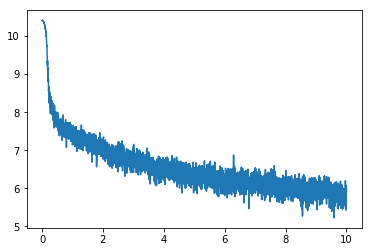

In [130]:
import matplotlib.pyplot as plt 
plt.plot(lrs, losses)
plt.show()

In [34]:
def get_triangular_lr2(lr_low, lr_high, iterations):
    iter1 = int(0.35*iterations)
    iter2 = int(0.85*iter1)
    iter3 = iterations - iter1 - iter2
    delta1 = (lr_high - lr_low)/iter1
    delta2 = (lr_high - lr_low)/(iter1 -1)
    lrs1 = [lr_low + i*delta1 for i in range(iter1)]
    lrs2 = [lr_high - i*(delta1) for i in range(0, iter2)]
    delta2 = (lrs2[-1] - lr_low)/(iter3)
    lrs3 = [lrs2[-1] - i*(delta2) for i in range(1, iter3+1)]
    return lrs1+lrs2+lrs3

## Training

In [35]:
criterion = nn.CrossEntropyLoss()

In [36]:
def evaluate(data_source):
    # Turn on evaluation mode which disables dropout.
    model.eval()
    total_loss = 0.
    ntokens = len(corpus.dictionary)
    hidden = model.init_hidden(batch_size)
    for i in range(0, data_source.size(0) - 1, bptt):
        data, targets = get_batch(data_source, i, bptt, evaluation=True)
        output, hidden = model(data, hidden)
        output_flat = output.view(-1, ntokens)
        total_loss += len(data) * criterion(output_flat, targets).data
        hidden = Variable(hidden.data) #.detach()
    return total_loss[0] / len(data_source)

In [37]:
def repackage_hidden(h):
    """Wraps hidden states in new Variables, to detach them from their history."""
    return Variable(h.data)

In [38]:
import time
import math
bptt = 35
clip = 0.25

def get_batch(source, i, bptt, evaluation=False):
    seq_len = min(bptt, len(source) - 1 - i)
    data = Variable(source[i:i+seq_len], volatile=evaluation)
    target = Variable(source[i+1:i+1+seq_len].view(-1))
    return data, target
    
def train_triangular_policy(model, epochs=4, lr_low=1e-4, lr_high=4):
    # Turn on training mode which enables dropout.
    start_time = time.time()
    ntokens = len(corpus.dictionary)
    iterations = epochs * ((train_data.size(0) - 1)//bptt + 1)
    lrs = get_triangular_lr2(lr_low, lr_high, iterations)
    idx = 0
    for epoch in range(epochs):
        total_loss = 0
        model.train()
        start_time = time.time()
        hidden = model.init_hidden(batch_size)
        for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
            lr = lrs[idx]
            data, targets = get_batch(train_data, i, bptt)
            # Starting each batch, we detach the hidden state from how it was previously produced.
            # If we didn't, the model would try backpropagating all the way to start of the dataset.
            hidden = Variable(hidden.data) #.detach()
            model.zero_grad()
            output, hidden = model(data, hidden)
            loss = criterion(output.view(-1, ntokens), targets)
            loss.backward()

            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            torch.nn.utils.clip_grad_norm(model.parameters(), clip)
            for p in model.parameters():
                p.data.add_(-lr, p.grad.data)

            total_loss += len(data)*loss.data
            idx += 1
        # results after each epoch
        val_loss = evaluate(val_data)
        elapsed = time.time() - start_time
        train_loss = total_loss[0]/len(train_data)
        print('| epoch {:3d} | lr {:02.5f} | t_loss {:5.2f} | t_ppl {:5.2f} | v_loss {:5.2f} | v_ppl {:5.2f}'.format(
             epoch, lr, train_loss, math.exp(train_loss), val_loss, math.exp(val_loss)))

In [39]:
steps = 10
nemb = 300
nhid = 300
nlayers = 2
ntokens = len(corpus.dictionary)
model = RNNModel(ntokens, nemb, nhid, nlayers).cuda()

In [40]:
ntokens

33279

In [41]:
train_triangular_policy(model, epochs=4, lr_low=4, lr_high=10)

| epoch   0 | lr 8.28489 | t_loss  6.52 | t_ppl 676.54 | v_loss  5.88 | v_ppl 356.71
| epoch   1 | lr 7.42878 | t_loss  5.81 | t_ppl 334.17 | v_loss  5.46 | v_ppl 234.26
| epoch   2 | lr 4.63954 | t_loss  5.47 | t_ppl 237.65 | v_loss  5.29 | v_ppl 198.54
| epoch   3 | lr 4.00000 | t_loss  5.30 | t_ppl 200.86 | v_loss  5.21 | v_ppl 182.89


In [42]:
train_triangular_policy(model, epochs=4, lr_low=4, lr_high=10)

| epoch   0 | lr 8.28489 | t_loss  5.23 | t_ppl 186.70 | v_loss  5.25 | v_ppl 191.28
| epoch   1 | lr 7.42878 | t_loss  5.21 | t_ppl 183.43 | v_loss  5.15 | v_ppl 173.28
| epoch   2 | lr 4.63954 | t_loss  5.05 | t_ppl 155.99 | v_loss  5.05 | v_ppl 156.07
| epoch   3 | lr 4.00000 | t_loss  4.95 | t_ppl 141.00 | v_loss  5.01 | v_ppl 150.53


In [43]:
train_triangular_policy(model, epochs=4, lr_low=2, lr_high=8)

| epoch   0 | lr 6.28489 | t_loss  4.89 | t_ppl 133.02 | v_loss  5.03 | v_ppl 152.95
| epoch   1 | lr 5.42878 | t_loss  4.92 | t_ppl 137.17 | v_loss  5.01 | v_ppl 150.15
| epoch   2 | lr 2.63954 | t_loss  4.81 | t_ppl 122.90 | v_loss  4.95 | v_ppl 140.68
| epoch   3 | lr 2.00000 | t_loss  4.75 | t_ppl 115.03 | v_loss  4.92 | v_ppl 136.56


In [44]:
train_triangular_policy(model, epochs=4, lr_low=1, lr_high=6)

| epoch   0 | lr 4.57074 | t_loss  4.72 | t_ppl 111.86 | v_loss  4.96 | v_ppl 142.24
| epoch   1 | lr 3.85731 | t_loss  4.75 | t_ppl 116.10 | v_loss  4.93 | v_ppl 138.41
| epoch   2 | lr 1.53295 | t_loss  4.68 | t_ppl 107.77 | v_loss  4.89 | v_ppl 132.51
| epoch   3 | lr 1.00000 | t_loss  4.64 | t_ppl 103.22 | v_loss  4.88 | v_ppl 131.12


In [45]:
train_triangular_policy(model, epochs=4, lr_low=1, lr_high=6)

| epoch   0 | lr 4.57074 | t_loss  4.63 | t_ppl 102.69 | v_loss  4.94 | v_ppl 139.68
| epoch   1 | lr 3.85731 | t_loss  4.68 | t_ppl 107.69 | v_loss  4.91 | v_ppl 135.64
| epoch   2 | lr 1.53295 | t_loss  4.61 | t_ppl 100.48 | v_loss  4.88 | v_ppl 131.01
| epoch   3 | lr 1.00000 | t_loss  4.57 | t_ppl 96.27 | v_loss  4.86 | v_ppl 128.77


In [46]:
train_triangular_policy(model, epochs=4, lr_low=1, lr_high=6)

| epoch   0 | lr 4.57074 | t_loss  4.57 | t_ppl 96.16 | v_loss  4.94 | v_ppl 139.16
| epoch   1 | lr 3.85731 | t_loss  4.62 | t_ppl 101.75 | v_loss  4.90 | v_ppl 134.75
| epoch   2 | lr 1.53295 | t_loss  4.55 | t_ppl 94.81 | v_loss  4.87 | v_ppl 130.20
| epoch   3 | lr 1.00000 | t_loss  4.51 | t_ppl 90.76 | v_loss  4.84 | v_ppl 126.99


In [47]:
train_triangular_policy(model, epochs=4, lr_low=0.5, lr_high=4)

| epoch   0 | lr 2.99952 | t_loss  4.50 | t_ppl 89.72 | v_loss  4.87 | v_ppl 130.73
| epoch   1 | lr 2.50012 | t_loss  4.53 | t_ppl 92.41 | v_loss  4.87 | v_ppl 130.96
| epoch   2 | lr 0.87306 | t_loss  4.48 | t_ppl 88.63 | v_loss  4.85 | v_ppl 127.19
| epoch   3 | lr 0.50000 | t_loss  4.46 | t_ppl 86.83 | v_loss  4.83 | v_ppl 124.72


In [48]:
train_triangular_policy(model, epochs=4, lr_low=0.01, lr_high=4)

| epoch   0 | lr 2.85945 | t_loss  4.46 | t_ppl 86.33 | v_loss  4.88 | v_ppl 131.15
| epoch   1 | lr 2.29014 | t_loss  4.49 | t_ppl 89.12 | v_loss  4.86 | v_ppl 129.46
| epoch   2 | lr 0.43529 | t_loss  4.46 | t_ppl 86.08 | v_loss  4.81 | v_ppl 122.88
| epoch   3 | lr 0.01000 | t_loss  4.47 | t_ppl 86.95 | v_loss  4.77 | v_ppl 118.41


In [49]:
train_triangular_policy(model, epochs=4, lr_low=0.01, lr_high=3)

| epoch   0 | lr 2.14531 | t_loss  4.43 | t_ppl 83.85 | v_loss  4.86 | v_ppl 129.56
| epoch   1 | lr 1.71867 | t_loss  4.45 | t_ppl 85.22 | v_loss  4.86 | v_ppl 128.80
| epoch   2 | lr 0.32870 | t_loss  4.43 | t_ppl 83.67 | v_loss  4.81 | v_ppl 122.69
| epoch   3 | lr 0.01000 | t_loss  4.44 | t_ppl 85.17 | v_loss  4.77 | v_ppl 117.78


In [ ]:
train_triangular_policy(model, epochs=4, lr_low=0.001, lr_high=2)

| epoch   0 | lr 1.42858 | t_loss  4.41 | t_ppl 82.25 | v_loss  4.84 | v_ppl 126.83
| epoch   1 | lr 1.14335 | t_loss  4.41 | t_ppl 82.16 | v_loss  4.83 | v_ppl 125.69


In [162]:
def save_model(m, p):
    torch.save(m.state_dict(), p)
    
def load_model(m, p):
    m.load_state_dict(torch.load(p))

p = PATH/"mode117.pth"
save_model(model, str(p))

In [13]:
p = PATH/"mode117.pth"
print(p)

/data/yinterian/wikitext-2/mode117.pth


## References
* https://github.com/pytorch/examples/tree/master/word_language_model
* http://colah.github.io/posts/2015-08-Understanding-LSTMs/